In [16]:
from torch import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focalLength = data['focal']

poses[12]
print(images.shape)
print(poses.shape)

width = images.shape[1]
height = images.shape[2]
# plt.imshow(images[3])

(106, 100, 100, 3)
(106, 4, 4)


In [38]:
numberOfFor = 0
model = nn.Sequential(
	# 3 for the initial x, y,z coordiante
	# then for each fourier feature, one for sin(x), sin(y), sin(z), 
	# and similarity 3 for cos
	nn.Linear(3 + 6*numberOfFor, 300),
	nn.ReLU(),
	nn.Linear(300, 300),
	nn.ReLU(),
	nn.Linear(300, 300),
	nn.ReLU(),
	nn.Linear(300, 300),
	nn.ReLU(),
	# 3 for r, g, b and last one for radiance
	nn.Linear(300, 4),
	nn.Sigmoid(),
)
model  = model.to(device)

In [172]:
# returns a two tensors, one with shape [width, height, 3] 
# representing the direction of a ray going through each pixel and another [width, height, 3] 
# representing the starting position of that same ray (all of which are the same) since 
# all rays start out at the origin
def getRays(width, height, focalLength, pose):
	xCoords = tensor([x for x in arange(width)])
	yCoords = tensor([y for y in arange(height)])
	x, y = torch.meshgrid(xCoords, yCoords)

	xShifted = x - width*0.5 # x coords in a [width, height] tensor
	yShifted = y - height*0.5 # y coords in a [width, height] tensor
	z = ones_like(x)  # z coords in a [width, height] tensor

	# match up each element of the 3 tensors (thats why using dim = 2)
	directionVectors = stack((xShifted, yShifted, z), dim=2)
	rotationMatrix = pose[0:3, 0:3]
	rotatedDirections = directionVectors@rotationMatrix
	
	origin =  tensor(pose[:3, 2])

	# all the rays have the same origin
	originTensor =  broadcast_to(origin, rotatedDirections.shape)
	return rotatedDirections, originTensor


	# print(directionVectors.shape)
	# print(xShifted[5][0])
	# print(yShifted[5][99])
	# print(x[4][6])
	# print(y[4][6])
dirs, pos = getRays(width, height, focalLength, poses[10])
print(rots[0][0], pos[0][0])

tensor([ 16.5580, -14.0819,  67.2944]) tensor([-0.8323, -0.5092,  0.2190])


In [15]:
def get_image():
	with torch.no_grad():
		# output = torch.zeros((size, size, 3))
		output = model(X)
		output = output.reshape(size, size, 3)
		output = output.to("cpu")
		return output


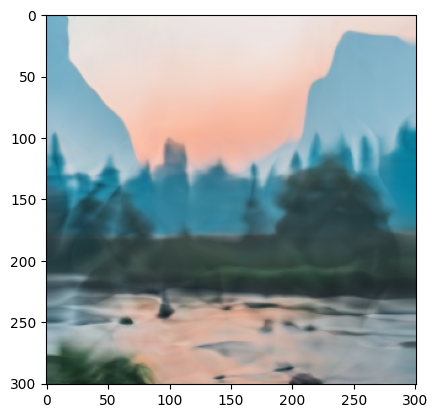

Loss is 0.0016113132005557418: 100%|██████████| 10000/10000 [59:36<00:00,  2.80it/s]


In [16]:
epochs = 10000
from tqdm import tqdm
from IPython.display import clear_output
def loss_fn(output, target):
		loss = torch.mean((output - target)**2)
		return loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

pbar = tqdm(range(epochs))
# pbar = range(epochs)

image_display = None

fig = plt.figure()
ax = fig.gca()
for n in pbar:
    preds = model(X)
    loss = loss_fn(preds, Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_description( f"Loss is {loss}")

    if(n % 10 == 0):
        clear_output()
        image  = get_image()
        plt.imshow(image)
        # if not image_display:
            # image_display = ax.imshow(image)
            # image_display = plt.imshow(image)
            # plt.show()
        # image_display.set_data(image)
        plt.show()
        # fig.canvas.draw()
        # fig.show()
        # image_display.draw()
		

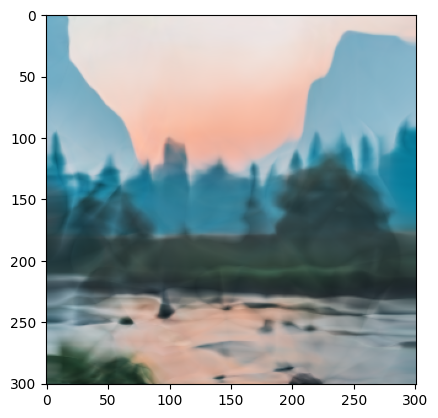

In [17]:
image  = get_image()
plt.imshow(image)